In [49]:
import torch
from torchvision import datasets
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [18]:
trans = T.Compose([
    T.ToTensor()
])

data = datasets.MNIST('./data', train=True, transform=trans, download=True)

In [32]:
[data[random.randint(0, len(data) -1)] for _ in range(25)][0][1]

1

In [33]:
g = make_grid([data[random.randint(0, len(data) -1)][0] for _ in range(25)], 5)

torch.Size([1, 28, 28])


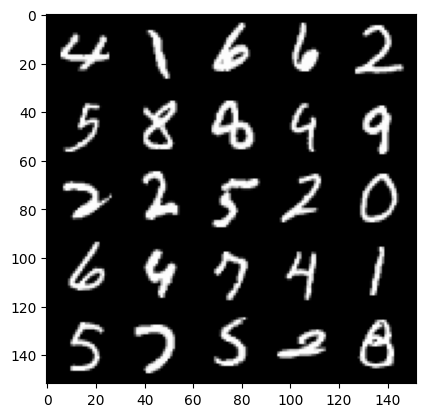

In [46]:
plt.imshow(g.permute(1, 2, 0))
print(data[0][0].shape)

In [37]:
def alphabar_t(t, T, s):
    return torch.cos(((t / T + s) / (1 + s)) * (torch.pi / 2)) ** 2

In [181]:
class SinusoidalPositionEmbeddings(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * - embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [192]:
relu = nn.functional.relu

class ConvBlock(nn.Module):
    def __init__(self, start_channels, channels, block_size, time_embed_dim=4):
        super().__init__()

        self.fw = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(
                        channels if l != 0 else start_channels, 
                        channels, 3, padding=1
                    ),

                    nn.ReLU()
                ) 
                for l in range(block_size)
            ]
        )

    def forward(self, x, t):

        return self.fw(x)

    


class Model(nn.Module):
    def __init__(self, u_depth=3, h_channels=32, block_size=3, dim=28, time_embed_dim=4):
        super().__init__()

        self.pos_embedder = SinusoidalPositionEmbeddings(dim)

        self.init_conv = nn.Conv2d(1, h_channels, 3, padding=1)

        self.downconvs = nn.ModuleList()
        self.upconvs = []
        self.conv_ts = []


        for i in range(u_depth):
            ch = h_channels * (2 ** i)

            dc = ConvBlock(ch//2 if i != 0 else ch, ch, block_size)

            self.downconvs.append(dc)

            uc = ConvBlock(ch * 2, ch, block_size)

            self.upconvs.append(uc)


            u = nn.Sequential(
                nn.ConvTranspose2d(ch * 2, ch, 2, stride=2),
                nn.ReLU()
            )

            self.conv_ts.append(u)

        self.upconvs = nn.ModuleList(self.upconvs[::-1])
        self.conv_ts = nn.ModuleList(self.conv_ts[::-1])


        bottom_ch = h_channels * (2 ** u_depth)

        self.bottom = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(bottom_ch // 2 if i == 0 else bottom_ch, bottom_ch, 3, padding=1),
                nn.ReLU(),
            ) for i in range(block_size)]
        )

        self.upsamples = nn.ModuleList()

        self.outconv = nn.Conv2d(h_channels, 1, 3, padding=1)


    def forward(self, x, t=None):
        if t is None:
            print("no t")
            t = torch.tensor([1])
        time_embedding = self.pos_embedder(t)
        print(time_embedding.shape)

        x = self.init_conv(x)

        u_outs = []

        for l in self.downconvs:
            x = l(x)
            u_outs.append(x)
            x = nn.functional.max_pool2d(x, 2, 2)

        u_outs.reverse()

        x = self.bottom(x)

        for up, fw, res in zip(self.conv_ts, self.upconvs, u_outs):
            x = up(x)
            print(res.shape)
            # break
            x = torch.cat((res, x), dim=1)
            x = fw(x)

        return self.outconv(x)

In [193]:
m = Model(u_depth = 2, h_channels = 10).to(device)
summary(m, (1, 28, 28), device=device)

no t
torch.Size([1, 28])
torch.Size([2, 20, 14, 14])
torch.Size([2, 10, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SinusoidalPositionEmbeddings-1                   [-1, 28]               0
            Conv2d-2           [-1, 10, 28, 28]             100
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             910
              ReLU-6           [-1, 10, 28, 28]               0
            Conv2d-7           [-1, 10, 28, 28]             910
              ReLU-8           [-1, 10, 28, 28]               0
         ConvBlock-9           [-1, 10, 28, 28]               0
           Conv2d-10           [-1, 20, 14, 14]           1,820
             ReLU-11           [-1, 20, 14, 14]               0
           Conv2d-12           [-1, 20, 14, 14]           3,620
            